#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

Because I want to transfer predicted values to probability and get a number between 0 and 1, I used sigmoid activation for the output layer. In practice, I'd like to know what the chances are that a review will be allocated to a "good" or "poor" review.

Because this is a classification problem with only two label classes, I utilized binary crossentropy loss (0 and 1).

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 29s 143ms/step - loss: 0.6403 - accuracy: 0.6193 - val_loss: 0.5422 - val_accuracy: 0.7220
Epoch 2/10
196/196 [==============================] - 27s 140ms/step - loss: 0.5025 - accuracy: 0.7570 - val_loss: 0.3920 - val_accuracy: 0.8301
Epoch 3/10
196/196 [==============================] - 28s 141ms/step - loss: 0.3114 - accuracy: 0.8734 - val_loss: 0.4695 - val_accuracy: 0.8082
Epoch 4/10
196/196 [==============================] - 28s 144ms/step - loss: 0.2535 - accuracy: 0.9006 - val_loss: 0.3578 - val_accuracy: 0.8587
Epoch 5/10
196/196 [==============================] - 28s 141ms/step - loss: 0.1659 - accuracy: 0.9409 - val_loss: 0.3779 - val_accuracy: 0.8570
Epoch 6/10
196/196 [==============================] - 28s 141ms/step - loss: 0.1180 - accuracy: 0.9609 - val_loss: 0.4067 - val_accuracy: 0.8551
Epoch 7/10
196/196 [==============================] - 28s 142ms/step - loss: 0.0800 - accuracy: 0.9760 - val_loss: 0.4485 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 8s - loss: 0.5738 - accuracy: 0.8448
accuracy: 84.48%


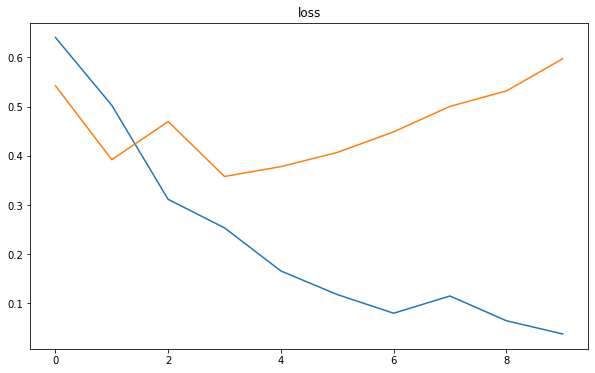

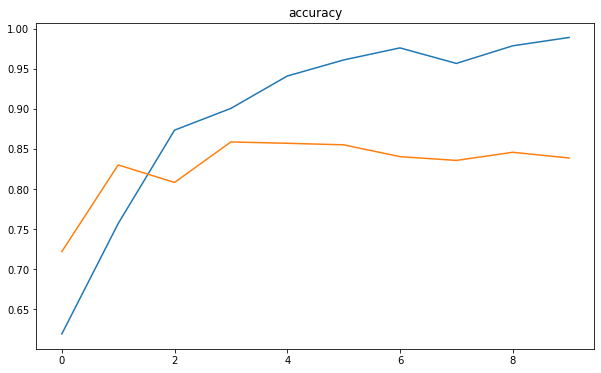

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

The original RNN model has 32 "hidden" unit, which corresponds to 1376 trainable parameters. In total the whole "SimpleRNN" model has 101,409 parameters and allows to achieve an accuracy of 84.85% on the test set.

This has been the baseline to the following two models, which I will call "LSTM" and "GRU" (because they have respectively LSTM and GRU units on the recursive layer). In these approaches, each unit has a bigger number of parameters than a SimpleRNN one, so to achieve a fair comparison I had to change it from 32 to:
- 13 (1,248 parameters) for LSTM, obtaining a model with a total of 101,262 trainable parameters;
- 16 (1,344 parameters) for GRU, obtaining a model with a total of 101,361 trainable parameters.

In that sense, I think that the models can now be considered fair among them.

In terms of performance, both "LSTM" and "GRU" model managed to improve the performance of the "SimpleRNN" one. In fact, I obtain an accuracy of 85.91% on the "LSTM" model, while the "GRU" one reaches only 84.90%. However, despite the accuracy metrics, from the plots it's very evident that all three models suffer a lot of overfitting so, in my opinion, applying regularization tecniques (like dropout) will allow the achievement of better results. Furthermore, in "LSTM" and "GRU" models, plots seem suggest that learning is more stable than "SimpleRNN" one, because in the latter both test and validation curves shows varius spikes (changes in the curve trend).

In fact, Keras implementation of LSTM and GRU layers allow to exploit GPU acceleration on compatible systems, while SimpleRRN does not. Running on colab instances, the difference in training time among those models is even more evident: SimpleRNN takes an average of over 60s per epoch, while the other two are around 4s/epoch (like 15 times faster).

In [ ]:
model = None
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(13))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


model.summary()

history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 13)                1248      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 101,262
Trainable params: 101,262
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 36s 220ms/step - loss: 0.6305 - accuracy: 0.6590 - val_loss: 0.4781 - val_accuracy: 0.8128
Epoch 2/10
157/157 [==============================] - 34s 218ms/step - loss: 0.3895 - accuracy: 0.8534 - val_loss: 0.3453 - val_accuracy: 0.8636
Epoch 3/10
157/157 [==============================] - 35s 224ms/step - loss: 0.2664 - ac

391/391 - 10s - loss: 0.4426 - accuracy: 0.8567
accuracy: 85.67%


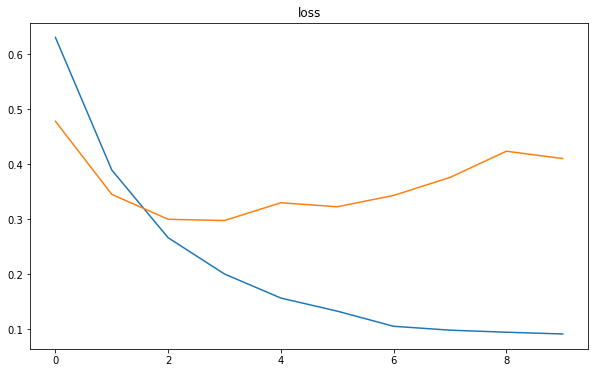

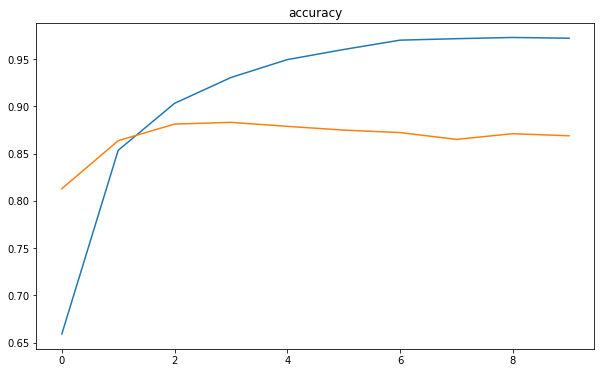

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
model = None
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(16))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


model.summary()

history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 37s 223ms/step - loss: 0.5904 - accuracy: 0.6769 - val_loss: 0.3843 - val_accuracy: 0.8336
Epoch 2/10
157/157 [==============================] - 35s 223ms/step - loss: 0.3066 - accuracy: 0.8735 - val_loss: 0.3309 - val_accuracy: 0.8624
Epoch 3/10
157/157 [==============================] - 35s 222ms/step - loss: 0.2172 - ac

391/391 - 9s - loss: 0.5286 - accuracy: 0.8533
accuracy: 85.33%


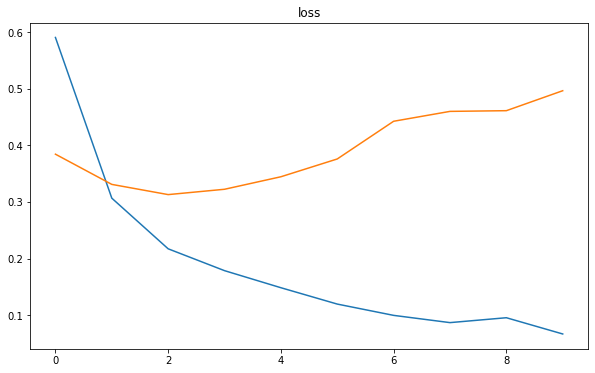

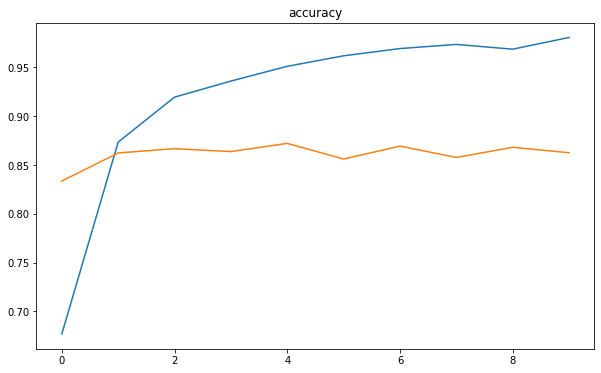

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 88s 540ms/step - loss: 0.6005 - accuracy: 0.6773 - val_loss: 0.5263 - val_accuracy: 0.7890
Epoch 2/5
157/157 [==============================] - 84s 533ms/step - loss: 0.4011 - accuracy: 0.8307 - val_loss: 0.5472 - val_accuracy: 0.7396
Epoch 3/5
157/157 [==============================] - 83s 532ms/step - loss: 0.3380 - accur

391/391 - 19s - loss: 0.3036 - accuracy: 0.8766
accuracy: 87.66%


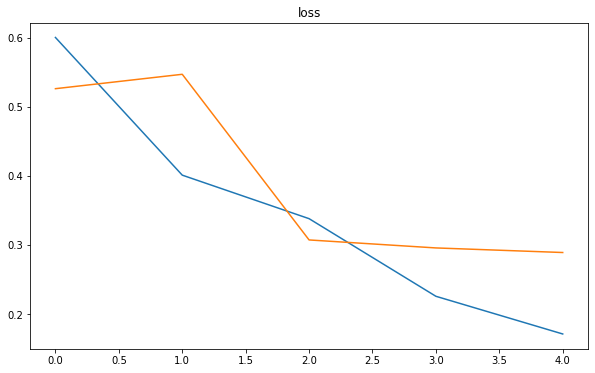

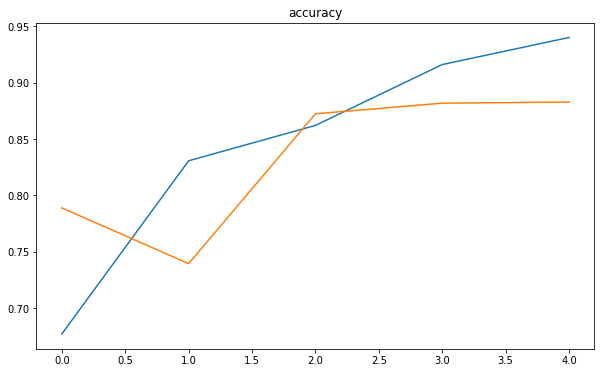

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

For the dropouts layers, I experimented with various probability values and found that 0.5 was the best.

The experiment below shows how I changed the optimizer and number of units in the bidirectional model (the one without dropout layers) to find the optimal combination for reducing overfitting. As can be seen, "adam" is the best optimizer, and 32 is the best number of units. (This is the same model as the one provided.)

I also tried to increase the amount of epochs, but it didn't make a significant difference.

The only difference I noticed was when I increased the batch size from 128 Overfitting was decreased as a result of this. I also experimented with larger numbers, however this resulted in a decrease in performance (lower accuracy).

In the last code cell, you can see the results of the best model without dropout that was used to reduce overfitting.

In [ ]:
model = None
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(16)))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                3456      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 103,489
Trainable params: 103,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 84s 409ms/step - loss: 0.6251 - accuracy: 0.6403 - val_loss: 0.4675 - val_accuracy: 0.7930
Epoch 2/10
196/196 [==============================] - 80s 406ms/step - loss: 0.4162 - accuracy: 0.818

391/391 - 15s - loss: 0.2675 - accuracy: 0.8912
accuracy: 89.12%


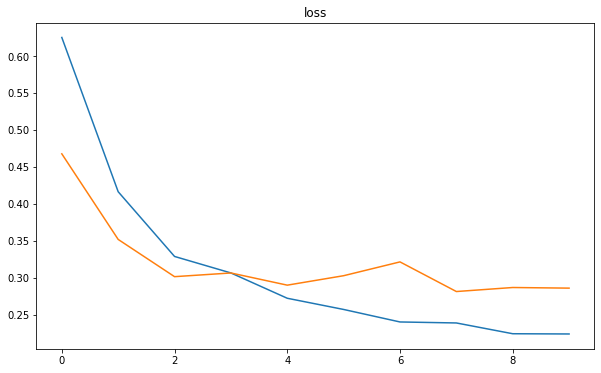

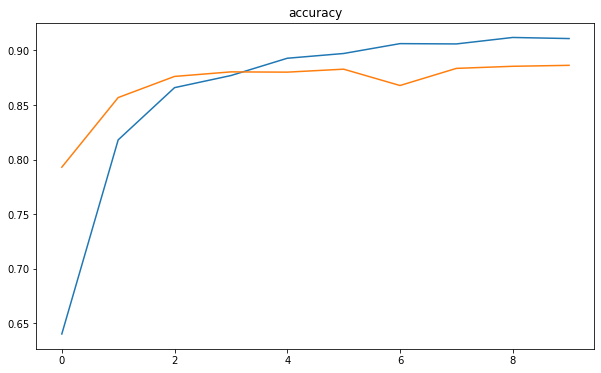

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))